In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image, make_grid
from torchsummary import summary
from sklearn.model_selection import train_test_split

from imageio import imread
from tqdm.notebook import tqdm
from functools import partial

In [2]:
# check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
!kaggle competitions download -c denoising-dirty-documents

 46% 10.0M/21.9M [00:00<00:00, 40.8MB/s]
100% 21.9M/21.9M [00:00<00:00, 62.8MB/s]
 27% 5.00M/18.5M [00:00<00:00, 38.0MB/s]
100% 18.5M/18.5M [00:00<00:00, 73.1MB/s]
 79% 5.00M/6.30M [00:00<00:00, 39.6MB/s]
100% 6.30M/6.30M [00:00<00:00, 40.3MB/s]
 53% 5.00M/9.39M [00:00<00:00, 19.0MB/s]
100% 9.39M/9.39M [00:00<00:00, 27.0MB/s]


In [7]:
# !unzip test.zip
# !unzip train.zip
# !unzip train_cleaned.zip

In [8]:
train = '/content/train'
test = '/content/test'
train_cleaned = '/content/train_cleaned'

In [9]:
def img_check(folder):
  count = 0
  test = set()
  path = sorted(os.listdir(folder))
  for img in path:
    im = Image.open(f'{folder}/{img}')
    test.add(im.size)
    count += 1
    # check if there are any RGB images
    if len(imread(f'{folder}/{img}').shape) > 2:
      print(img)
  return test, print(f'There are {count} in {folder}, sizes:')

In [10]:
img_check(test)

There are 72 in /content/test, sizes:


({(540, 258), (540, 420)}, None)

In [11]:
img_check(train)

There are 144 in /content/train, sizes:


({(540, 258), (540, 420)}, None)

In [12]:
img_check(train_cleaned)

There are 144 in /content/train_cleaned, sizes:


({(540, 258), (540, 420)}, None)

In [13]:
stats = (0.5),(0.5) # mean and stnd to normalize greyscale images (probaly not requiered)
transform = transforms.Compose([transforms.Resize((540, 420)),
                               transforms.ToTensor(),
                               transforms.Normalize(*stats)])

In [14]:
class Docs(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = sorted(os.listdir(main_dir))

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc)
        tensor_image = self.transform(image)
        return tensor_image

In [15]:
# Creating datasets
docs_test = Docs(test, transform=transform)
docs_train_x = Docs(train, transform=transform)
docs_train_y = Docs(train_cleaned, transform=transform)

In [16]:
# spliting for Train and Test
X_train, X_val, y_train, y_val = train_test_split(docs_train_x, docs_train_y, test_size = 0.15)

In [17]:
len(X_train), len(y_train), len(X_val), len(y_val)

(122, 122, 22, 22)

In [45]:
# dir for denoised images
os.makedirs('Denoised', exist_ok=True)
# dir for model weights
os.makedirs('Denoised/model_weights', exist_ok=True)
# function to save images: original, noised, denoised
def save_samples(x, y_true, y_predicted, epoch):
    
    orig_name = 'original-images-{0:0=4d}.png'.format(epoch)
    noise_name = 'images-with-noise-{0:0=4d}.png'.format(epoch)
    denoised_name = 'denoised-images-{0:0=4d}.png'.format(epoch)
    
    save_image(y_true, os.path.join('Denoised', orig_name))
    save_image(x, os.path.join('Denoised', noise_name))
    save_image(y_predicted, os.path.join('Denoised', denoised_name))
    
    print(f'Saving images for epoch {epoch}')

In [19]:
# function to check if gradients are exploding
def check_grads(model, value):
    grads = []
    for p in model.parameters():
        grads.append(p.grad.data.norm(2).item())

    grads = np.array(grads)
    if grads.mean() > value:
        print(f"WARNING! gradients mean is over {value}")
        print('max:', grads.max())
    if grads.max() > value:
        print(f"WARNING! gradients max is over {value}")
        print('max:', grads.max())

In [20]:
# Combaning data for Dataloader 
class Datasetter(Dataset):
  def __init__(self, x_train, y_train):
    self.x_train = x_train
    self.y_train = y_train
  
  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    return self.x_train[idx], self.y_train[idx]

In [21]:
batch_size = 5

training_set = Datasetter(X_train, y_train)
test_set = Datasetter(X_val, y_val)

train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
final_test = DataLoader(docs_test, batch_size=batch_size)

In [27]:
def show_img(lis,num):
  f, ax = plt.subplots(1,2, figsize=(15,15))
  ax[0].imshow(np.squeeze(lis[num][0]), cmap='gray')
  ax[1].imshow(np.squeeze(lis[num][1]), cmap='gray')

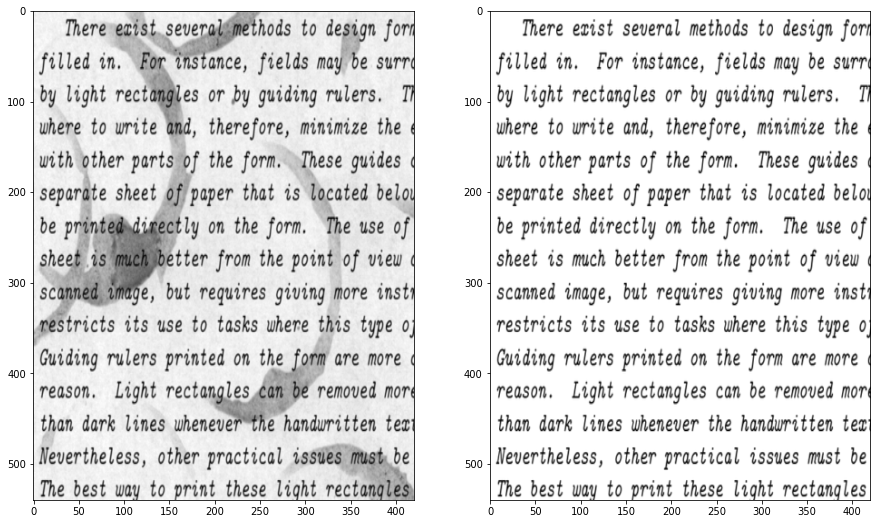

In [28]:
show_img(test_set, 2)

In [29]:
# set class of our autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                                    nn.Conv2d(1, 64, kernel_size=3, padding=2),
                                    nn.ReLU(inplace = True),
                                    # nn.LeakyReLU(0.2, inplace=True),                                     

                                    nn.Conv2d(64, 128, kernel_size=3, padding=2),
                                    nn.ReLU(inplace = True),
                                    nn.BatchNorm2d(128)                                
                                    )
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, return_indices=True)
        # self.dropout = nn.Dropout(p=0.5)
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2)
       
        self.decoder = nn.Sequential(    
                                    nn.ConvTranspose2d(128, 64, kernel_size=3, padding=2),
#                                     nn.BatchNorm2d(64),
                                    nn.ReLU(inplace = True),                                    

            
                                    nn.ConvTranspose2d(64, 1, kernel_size=3, padding=2),
#                                     nn.BatchNorm2d(64),
                                    nn.ReLU(inplace = True),                                    

                                    )


    def forward(self, x):
        x = self.encoder(x)
        x, i = self.max_pool(x)
        x = self.max_unpool(x, i)
        x = self.decoder(x)
        return x

In [30]:
model = ConvAutoencoder().to(device)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 2, factor = .5, threshold=0.003, verbose = True)
summary(model, (1, 540, 420))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 542, 422]             640
              ReLU-2         [-1, 64, 542, 422]               0
            Conv2d-3        [-1, 128, 544, 424]          73,856
              ReLU-4        [-1, 128, 544, 424]               0
       BatchNorm2d-5        [-1, 128, 544, 424]             256
         MaxPool2d-6  [[-1, 128, 272, 212], [-1, 128, 272, 212]]               0
       MaxUnpool2d-7        [-1, 128, 544, 424]               0
   ConvTranspose2d-8         [-1, 64, 542, 422]          73,792
              ReLU-9         [-1, 64, 542, 422]               0
  ConvTranspose2d-10          [-1, 1, 540, 420]             577
             ReLU-11          [-1, 1, 540, 420]               0
Total params: 149,121
Trainable params: 149,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (M

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:693: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch._C._nn.max_pool2d_with_indices(input, kernel_size, stride, padding, dilation, ceil_mode)


In [31]:
# function to plot losses
def plot_history(history, grid=True):
    plt.style.use('ggplot')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    ax1.plot(history['train_losses'], label='Loss on train dataset')
    ax2.plot(history['test_losses'], label='Loss on test dataset')
    ax1.set_xlabel('Epoch')
    ax2.set_xlabel('Epoch')
    ax1.set_ylabel('Loss, MSE')
    ax1.set_title('Loss on train dataset')
    ax2.set_title('Loss on test dataset')
    plt.show()

In [70]:
# main function to train model
def training_loop(model, epochs, history=None, plot_every=None, progress=True):
    torch.cuda.empty_cache()
    
    history = history or {
        'train_losses': [],
        'test_losses': [],
        'fixed_images_losses': []
    }
    
    # tqdm
    tqdm_ = partial(tqdm,
                    disable=not progress, # no progress bar
                    leave=True) # remove bar when finished
    
    start_epoch = len(history['train_losses'])
    for epoch in range(start_epoch+1, start_epoch+epochs):
        print(f'epoch {epoch}')
        print('current learning rate:', optimizer.param_groups[0]["lr"])
        
        # Setting train mode
        model.train()
        train_loss = 0 # for saving losses of train dataset
        for train_data in tqdm_(train_loader, desc='train'):
            
            x_train_batch, y_train_batch = train_data
            
            # Before the backward pass, use the optimizer object to zero all of the
            # gradients for the variables it will update (which are the learnable
            # weights of the model). This is because by default, gradients are
            # accumulated in buffers( i.e, not overwritten) whenever .backward()
            # is called. Checkout docs of torch.autograd.backward for more details.
            optimizer.zero_grad()
            
            # Forward pass: compute predicted y by passing x to the model
            y_pred = model(x_train_batch.to(device))
            
            # Computing loss
            loss = loss_fn(y_pred, y_train_batch.to(device))
            
            # Saving loss for this batch
            train_loss += loss.item()
            
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            
            # Calling the step function on an optimizer makes an update to its parameters
            optimizer.step()
            
        # Saving loss for this epoch
        history['train_losses'].append(train_loss)
        
        # Setting test mode
        model.eval()       
        test_loss = 0 # for saving losses on test dataset
        for test_data in tqdm_(test_loader, desc='test'):
            
            x_test_batch, y_test_batch = test_data

            # set inference_mode
            with torch.inference_mode():
                y_pred = model(x_test_batch.to(device))
                
            # Computing loss
            loss = loss_fn(y_pred, y_test_batch.to(device))
            
            # Saving loss for this batch
            test_loss += loss.item()
            
        # Calling the step function on a learning rate scheduler
        lr_scheduler.step(test_loss) 
            
        # Saving loss for this epoch
        history['test_losses'].append(test_loss)
        
        # Printing losses
        print(f'train: loss {history["train_losses"][-1]:.4f}\n'
              f'test: loss {history["test_losses"][-1]:.4f}\n')
        
        num = np.random.randint(0, 1)
        # Saving images from the last x_test_batch of the epoch
        save_samples(x=x_test_batch[num], y_true=y_test_batch[num], y_predicted=y_pred[num], epoch=epoch)

        if plot_every and epoch % plot_every == 0:
            plot_history(history)
        else:
            print()
        
        # Saving models
        if epoch % 10 == 0:
            print('Saving model weights')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, f'Denoised/model_weights/denoiser{epoch}.pth')

    
    # Not to plot double
    if not plot_every or epoch % plot_every > 0:
        plot_history(history)
    
    # Show some images from the last epoch
    x_test_batch = x_test_batch.cpu()
    y_test_batch = y_test_batch.cpu()
    y_pred = y_pred.cpu()
    
    fig = plt.figure(figsize=(15,10))
    
    fig.add_subplot(1,3,1)
    plt.title('Image with noise')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.squeeze(x_test_batch[0]), cmap='gray')

    fig.add_subplot(1,3,2)
    plt.title('Original image')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.squeeze(y_test_batch[0]), cmap='gray')
    
    fig.add_subplot(1,3,3)
    plt.title('Denoised image')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.squeeze(y_pred[0]), cmap='gray')

    return history

epoch 1
current learning rate: 1.52587890625e-08


train:   0%|          | 0/25 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

train: loss 0.7450
test: loss 0.1356

Saving images for epoch 1

epoch 2
current learning rate: 1.52587890625e-08


train:   0%|          | 0/25 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

train: loss 0.7382
test: loss 0.1273

Saving images for epoch 2

epoch 3
current learning rate: 1.52587890625e-08


train:   0%|          | 0/25 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

train: loss 0.7459
test: loss 0.1274

Saving images for epoch 3

epoch 4
current learning rate: 1.52587890625e-08


train:   0%|          | 0/25 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

train: loss 0.7420
test: loss 0.1276

Saving images for epoch 4

epoch 5
current learning rate: 1.52587890625e-08


train:   0%|          | 0/25 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

train: loss 0.7461
test: loss 0.1314

Saving images for epoch 5

epoch 6
current learning rate: 1.52587890625e-08


train:   0%|          | 0/25 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

train: loss 0.7534
test: loss 0.1402

Saving images for epoch 6

epoch 7
current learning rate: 1.52587890625e-08


train:   0%|          | 0/25 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

train: loss 0.7477
test: loss 0.1301

Saving images for epoch 7

epoch 8
current learning rate: 1.52587890625e-08


train:   0%|          | 0/25 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

train: loss 0.7424
test: loss 0.1249

Saving images for epoch 8

epoch 9
current learning rate: 1.52587890625e-08


train:   0%|          | 0/25 [00:00<?, ?it/s]

test:   0%|          | 0/5 [00:00<?, ?it/s]

train: loss 0.7533
test: loss 0.1233

Saving images for epoch 9



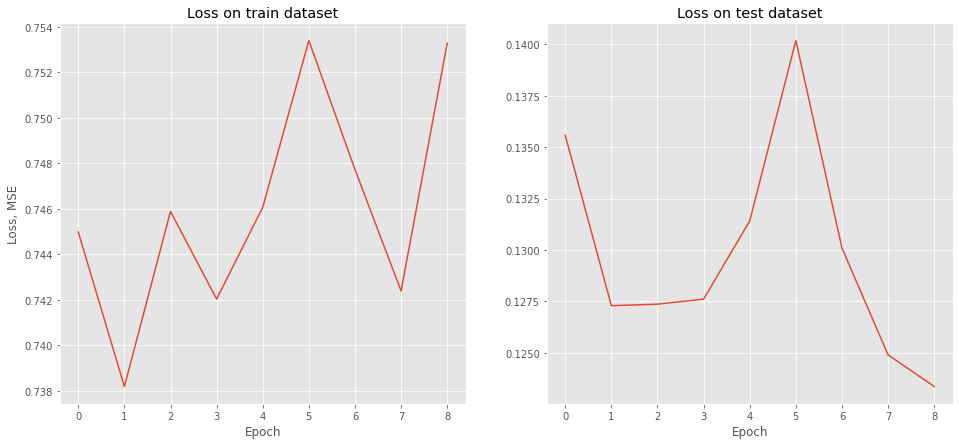

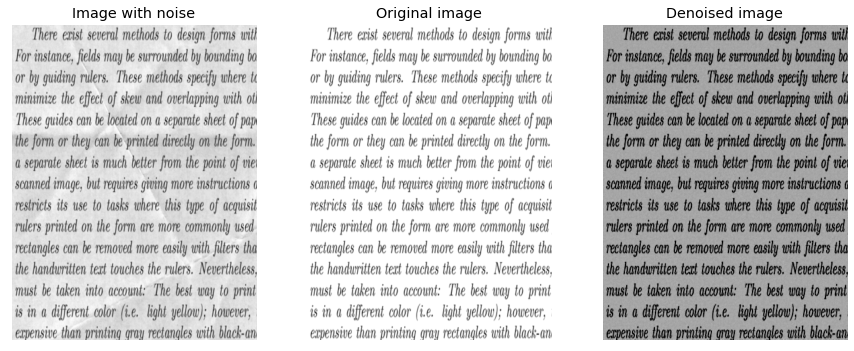

In [72]:
history = training_loop(model, 10)